# Transformer Part 4: 编码器 (Encoder)

本notebook实现Transformer的编码器结构，包括：
1. 位置前馈网络（Positionwise Feed-Forward Network）
2. 编码器层（Encoder Layer）
3. 完整编码器（Encoder）
4. 与PyTorch官方实现的对比
5. 注意力权重可视化

编码器是Transformer的核心组件之一，负责处理输入序列并生成上下文表示。

In [1]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. 位置前馈网络 (Positionwise Feed-Forward Network)

**原论文描述**：
"In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically."

**数学公式**（来自原论文）：

$$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2$$

其中：
- 输入维度：$d_{model} = 512$
- 隐藏层维度：$d_{ff} = 2048$
- 激活函数：ReLU
- 应用于每个位置（positionwise）

**特点**：
1. 相同的网络应用于所有位置
2. 使用ReLU激活函数
3. 维度先扩展再压缩（512 → 2048 → 512）

In [2]:
class PositionwiseFeedForward(nn.Module):
    """
    位置前馈网络实现
    
    参数:
        d_model: 模型维度（512）
        d_ff: 前馈网络隐藏层维度（2048）
        dropout: dropout概率
    """
    def __init__(self, d_model=512, d_ff=2048, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        
        # 第一层线性变换：d_model -> d_ff
        self.w_1 = nn.Linear(d_model, d_ff)
        
        # 第二层线性变换：d_ff -> d_model
        self.w_2 = nn.Linear(d_ff, d_model)
        
        # Dropout层
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        """
        前向传播
        
        参数:
            x: 输入张量，形状为 [batch_size, seq_len, d_model]
        
        返回:
            输出张量，形状与输入相同
        """
        # 线性变换 + ReLU激活 + dropout + 线性变换
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

def test_feedforward():
    """
    测试位置前馈网络
    """
    print("测试位置前馈网络...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    d_ff = 2048
    
    # 创建前馈网络
    ffn = PositionwiseFeedForward(d_model, d_ff)
    
    # 创建测试输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    output = ffn(x)
    
    print(f"输入形状: {x.shape}")
    print(f"输出形状: {output.shape}")
    
    # 验证输出形状
    assert output.shape == x.shape, f"输出形状错误: {output.shape}"
    print("✓ 形状测试通过")
    
    # 验证参数数量
    total_params = sum(p.numel() for p in ffn.parameters())
    expected_params = d_model * d_ff + d_ff + d_ff * d_model + d_model  # 两层线性层
    print(f"总参数量: {total_params}")
    print(f"期望参数量: {expected_params}")
    
    if total_params == expected_params:
        print("✓ 参数量正确")
    else:
        print("⚠ 参数量可能有误")
    
    print("✓ 位置前馈网络测试完成")
    
    return output

# 运行测试
output = test_feedforward()

测试位置前馈网络...
输入形状: torch.Size([2, 10, 512])
输出形状: torch.Size([2, 10, 512])
✓ 形状测试通过
总参数量: 2099712
期望参数量: 2099712
✓ 参数量正确
✓ 位置前馈网络测试完成


## 2. 编码器层 (Encoder Layer)

**原论文描述**：
"Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network."

**架构**：
1. 多头自注意力子层（带残差连接和层归一化）
2. 位置前馈网络子层（带残差连接和层归一化）

**数学公式**（来自原论文）：

1. 自注意力子层：$LayerNorm(x + MultiHeadAttention(x, x, x))$
2. 前馈子层：$LayerNorm(x + FeedForward(x))$

**特点**：
- 使用残差连接（Residual Connection）
- 使用层归一化（Layer Normalization）
- 使用dropout进行正则化

In [3]:
class MultiHeadAttention(nn.Module):
    """
    多头注意力机制（简化版，用于测试）
    
    参数:
        d_model: 模型维度
        n_heads: 注意力头数
        dropout: dropout概率
    """
    def __init__(self, d_model=512, n_heads=8, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        
        # 线性变换层
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        
        self.dropout = nn.Dropout(dropout)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        缩放点积注意力
        """
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        output = torch.matmul(attention_weights, V)
        return output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        """
        前向传播
        """
        batch_size = query.size(0)
        seq_len = query.size(1)
        
        # 线性变换
        Q = self.w_q(query).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        
        # 注意力计算
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 合并多头
        attention_output = attention_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        # 输出线性变换
        output = self.w_o(attention_output)
        
        return output, attention_weights

class EncoderLayer(nn.Module):
    """
    编码器层实现
    
    参数:
        d_model: 模型维度
        n_heads: 注意力头数
        d_ff: 前馈网络隐藏层维度
        dropout: dropout概率
    """
    def __init__(self, d_model=512, n_heads=8, d_ff=2048, dropout=0.1):
        super(EncoderLayer, self).__init__()
        
        # 多头自注意力
        self.self_attention = MultiHeadAttention(d_model, n_heads, dropout)
        
        # 位置前馈网络
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)
        
        # 层归一化
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        """
        前向传播
        
        参数:
            x: 输入张量，形状为 [batch_size, seq_len, d_model]
            mask: 掩码张量
        
        返回:
            输出张量和注意力权重
        """
        # 自注意力子层
        attn_output, attention_weights = self.self_attention(x, x, x, mask)
        attn_output = self.dropout(attn_output)
        out1 = self.norm1(x + attn_output)  # 残差连接 + 层归一化
        
        # 前馈子层
        ff_output = self.feed_forward(out1)
        ff_output = self.dropout(ff_output)
        out2 = self.norm2(out1 + ff_output)  # 残差连接 + 层归一化
        
        return out2, attention_weights

def test_encoder_layer():
    """
    测试编码器层
    """
    print("测试编码器层...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    n_heads = 8
    d_ff = 2048
    
    # 创建编码器层
    encoder_layer = EncoderLayer(d_model, n_heads, d_ff)
    
    # 创建测试输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    output, attention_weights = encoder_layer(x)
    
    print(f"输入形状: {x.shape}")
    print(f"输出形状: {output.shape}")
    print(f"注意力权重形状: {attention_weights.shape}")
    
    # 验证输出形状
    assert output.shape == x.shape, f"输出形状错误: {output.shape}"
    print("✓ 形状测试通过")
    
    # 验证注意力权重形状
    expected_attn_shape = (batch_size, n_heads, seq_len, seq_len)
    assert attention_weights.shape == expected_attn_shape, f"注意力权重形状错误: {attention_weights.shape}"
    print("✓ 注意力权重形状正确")
    
    print("✓ 编码器层测试完成")
    
    return output, attention_weights

# 运行测试
output, attention_weights = test_encoder_layer()

测试编码器层...
输入形状: torch.Size([2, 10, 512])
输出形状: torch.Size([2, 10, 512])
注意力权重形状: torch.Size([2, 8, 10, 10])
✓ 形状测试通过
✓ 注意力权重形状正确
✓ 编码器层测试完成


## 3. 完整编码器 (Encoder)

**原论文描述**：
"The encoder is composed of a stack of N = 6 identical layers."

**架构**：
1. 输入嵌入（Input Embedding）
2. 位置编码（Positional Encoding）
3. N个相同的编码器层（N=6）

**特点**：
- 6个相同的编码器层堆叠
- 每层包含自注意力和前馈网络
- 使用残差连接和层归一化

In [4]:
class Encoder(nn.Module):
    """
    完整编码器实现
    
    参数:
        d_model: 模型维度
        n_heads: 注意力头数
        d_ff: 前馈网络隐藏层维度
        n_layers: 编码器层数
        dropout: dropout概率
    """
    def __init__(self, d_model=512, n_heads=8, d_ff=2048, n_layers=6, dropout=0.1):
        super(Encoder, self).__init__()
        
        # 编码器层堆叠
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        
        # 层归一化
        self.norm = nn.LayerNorm(d_model)
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, mask=None):
        """
        前向传播
        
        参数:
            x: 输入张量（已包含位置编码的嵌入），形状为 [batch_size, seq_len, d_model]
            mask: 掩码张量
        
        返回:
            输出张量和所有层的注意力权重
        """
        # 通过所有编码器层
        attention_weights_list = []
        
        for layer in self.layers:
            x, attention_weights = layer(x, mask)
            attention_weights_list.append(attention_weights)
        
        # 最终层归一化
        output = self.norm(x)
        
        return output, attention_weights_list

def test_encoder():
    """
    测试完整编码器
    """
    print("测试完整编码器...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 6
    
    # 创建编码器
    encoder = Encoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建测试输入（模拟嵌入+位置编码）
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    output, attention_weights_list = encoder(x)
    
    print(f"输入形状: {x.shape}")
    print(f"输出形状: {output.shape}")
    print(f"编码器层数: {len(attention_weights_list)}")
    
    # 验证输出形状
    assert output.shape == x.shape, f"输出形状错误: {output.shape}"
    print("✓ 形状测试通过")
    
    # 验证注意力权重数量
    assert len(attention_weights_list) == n_layers, f"注意力权重数量错误: {len(attention_weights_list)}"
    print("✓ 注意力权重数量正确")
    
    # 验证每层注意力权重形状
    expected_attn_shape = (batch_size, n_heads, seq_len, seq_len)
    for i, attn_weights in enumerate(attention_weights_list):
        assert attn_weights.shape == expected_attn_shape, f"第{i}层注意力权重形状错误: {attn_weights.shape}"
    print("✓ 所有层注意力权重形状正确")
    
    print("✓ 完整编码器测试完成")
    
    return output, attention_weights_list

# 运行测试
output, attention_weights_list = test_encoder()

测试完整编码器...
输入形状: torch.Size([2, 10, 512])
输出形状: torch.Size([2, 10, 512])
编码器层数: 6
✓ 形状测试通过
✓ 注意力权重数量正确
✓ 所有层注意力权重形状正确
✓ 完整编码器测试完成


## 4. 带掩码的编码器测试

In [5]:
def test_encoder_with_mask():
    """
    测试带掩码的编码器
    """
    print("测试带掩码的编码器...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 6
    
    # 创建编码器
    encoder = Encoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建测试输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 创建填充掩码（模拟不同长度的序列）
    # 假设第一个序列长度为8，第二个为6
    mask = torch.zeros(batch_size, 1, 1, seq_len)
    mask[0, 0, 0, 8:] = 1  # 第一个序列，屏蔽后2个位置
    mask[1, 0, 0, 6:] = 1  # 第二个序列，屏蔽后4个位置
    mask = mask == 0  # 转换为布尔掩码（True表示保留）
    
    print(f"输入形状: {x.shape}")
    print(f"掩码形状: {mask.shape}")
    
    # 前向传播（带掩码）
    output_with_mask, attention_weights_with_mask = encoder(x, mask)
    
    # 前向传播（无掩码）
    output_without_mask, attention_weights_without_mask = encoder(x)
    
    print(f"带掩码输出形状: {output_with_mask.shape}")
    print(f"无掩码输出形状: {output_without_mask.shape}")
    
    # 比较输出差异
    diff = torch.abs(output_with_mask - output_without_mask).mean().item()
    print(f"平均绝对差异: {diff:.6f}")
    
    if diff > 1e-6:
        print("✓ 掩码生效，输出有差异")
    else:
        print("⚠ 掩码可能未生效")
    
    # 分析注意力权重
    # 检查第一层注意力权重
    first_layer_attn = attention_weights_with_mask[0]  # [batch_size, n_heads, seq_len, seq_len]
    
    print(f"第一层注意力权重形状: {first_layer_attn.shape}")
    
    # 检查被屏蔽位置的注意力权重
    # 对于第一个序列，位置8-9应该被屏蔽
    masked_positions_attn = first_layer_attn[0, :, :8, 8:].mean().item()  # 前8个位置对后2个位置的关注
    print(f"被屏蔽位置的平均注意力权重: {masked_positions_attn:.6f}")
    
    if masked_positions_attn < 0.01:
        print("✓ 被屏蔽位置的注意力权重接近0")
    else:
        print("⚠ 被屏蔽位置的注意力权重较高")
    
    print("✓ 带掩码编码器测试完成")
    
    return output_with_mask, attention_weights_with_mask

# 运行测试
output_with_mask, attention_weights_with_mask = test_encoder_with_mask()

测试带掩码的编码器...
输入形状: torch.Size([2, 10, 512])
掩码形状: torch.Size([2, 1, 1, 10])
带掩码输出形状: torch.Size([2, 10, 512])
无掩码输出形状: torch.Size([2, 10, 512])
平均绝对差异: 0.364894
✓ 掩码生效，输出有差异
第一层注意力权重形状: torch.Size([2, 8, 10, 10])
被屏蔽位置的平均注意力权重: 0.000000
✓ 被屏蔽位置的注意力权重接近0
✓ 带掩码编码器测试完成


## 5. 注意力权重可视化

可视化注意力权重...
注意力权重形状: torch.Size([1, 8, 20, 20])


e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 26597 (\N{CJK UNIFIED IDEOGRAPH-67E5}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 35810 (\N{CJK UNIFIED IDEOGRAPH-8BE2}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 20301 (\N{CJK UNIFIED IDEOGRAPH-4F4D}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 32622 (\N{CJK UNIFIED IDEOGRAPH-7F6E}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 27880 (\N{CJK UNIFIED IDEOGRAPH-6CE8}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
e:\Application\Anaconda\envs\llm\lib\site-packages\seaborn\utils.py:61: UserWarn

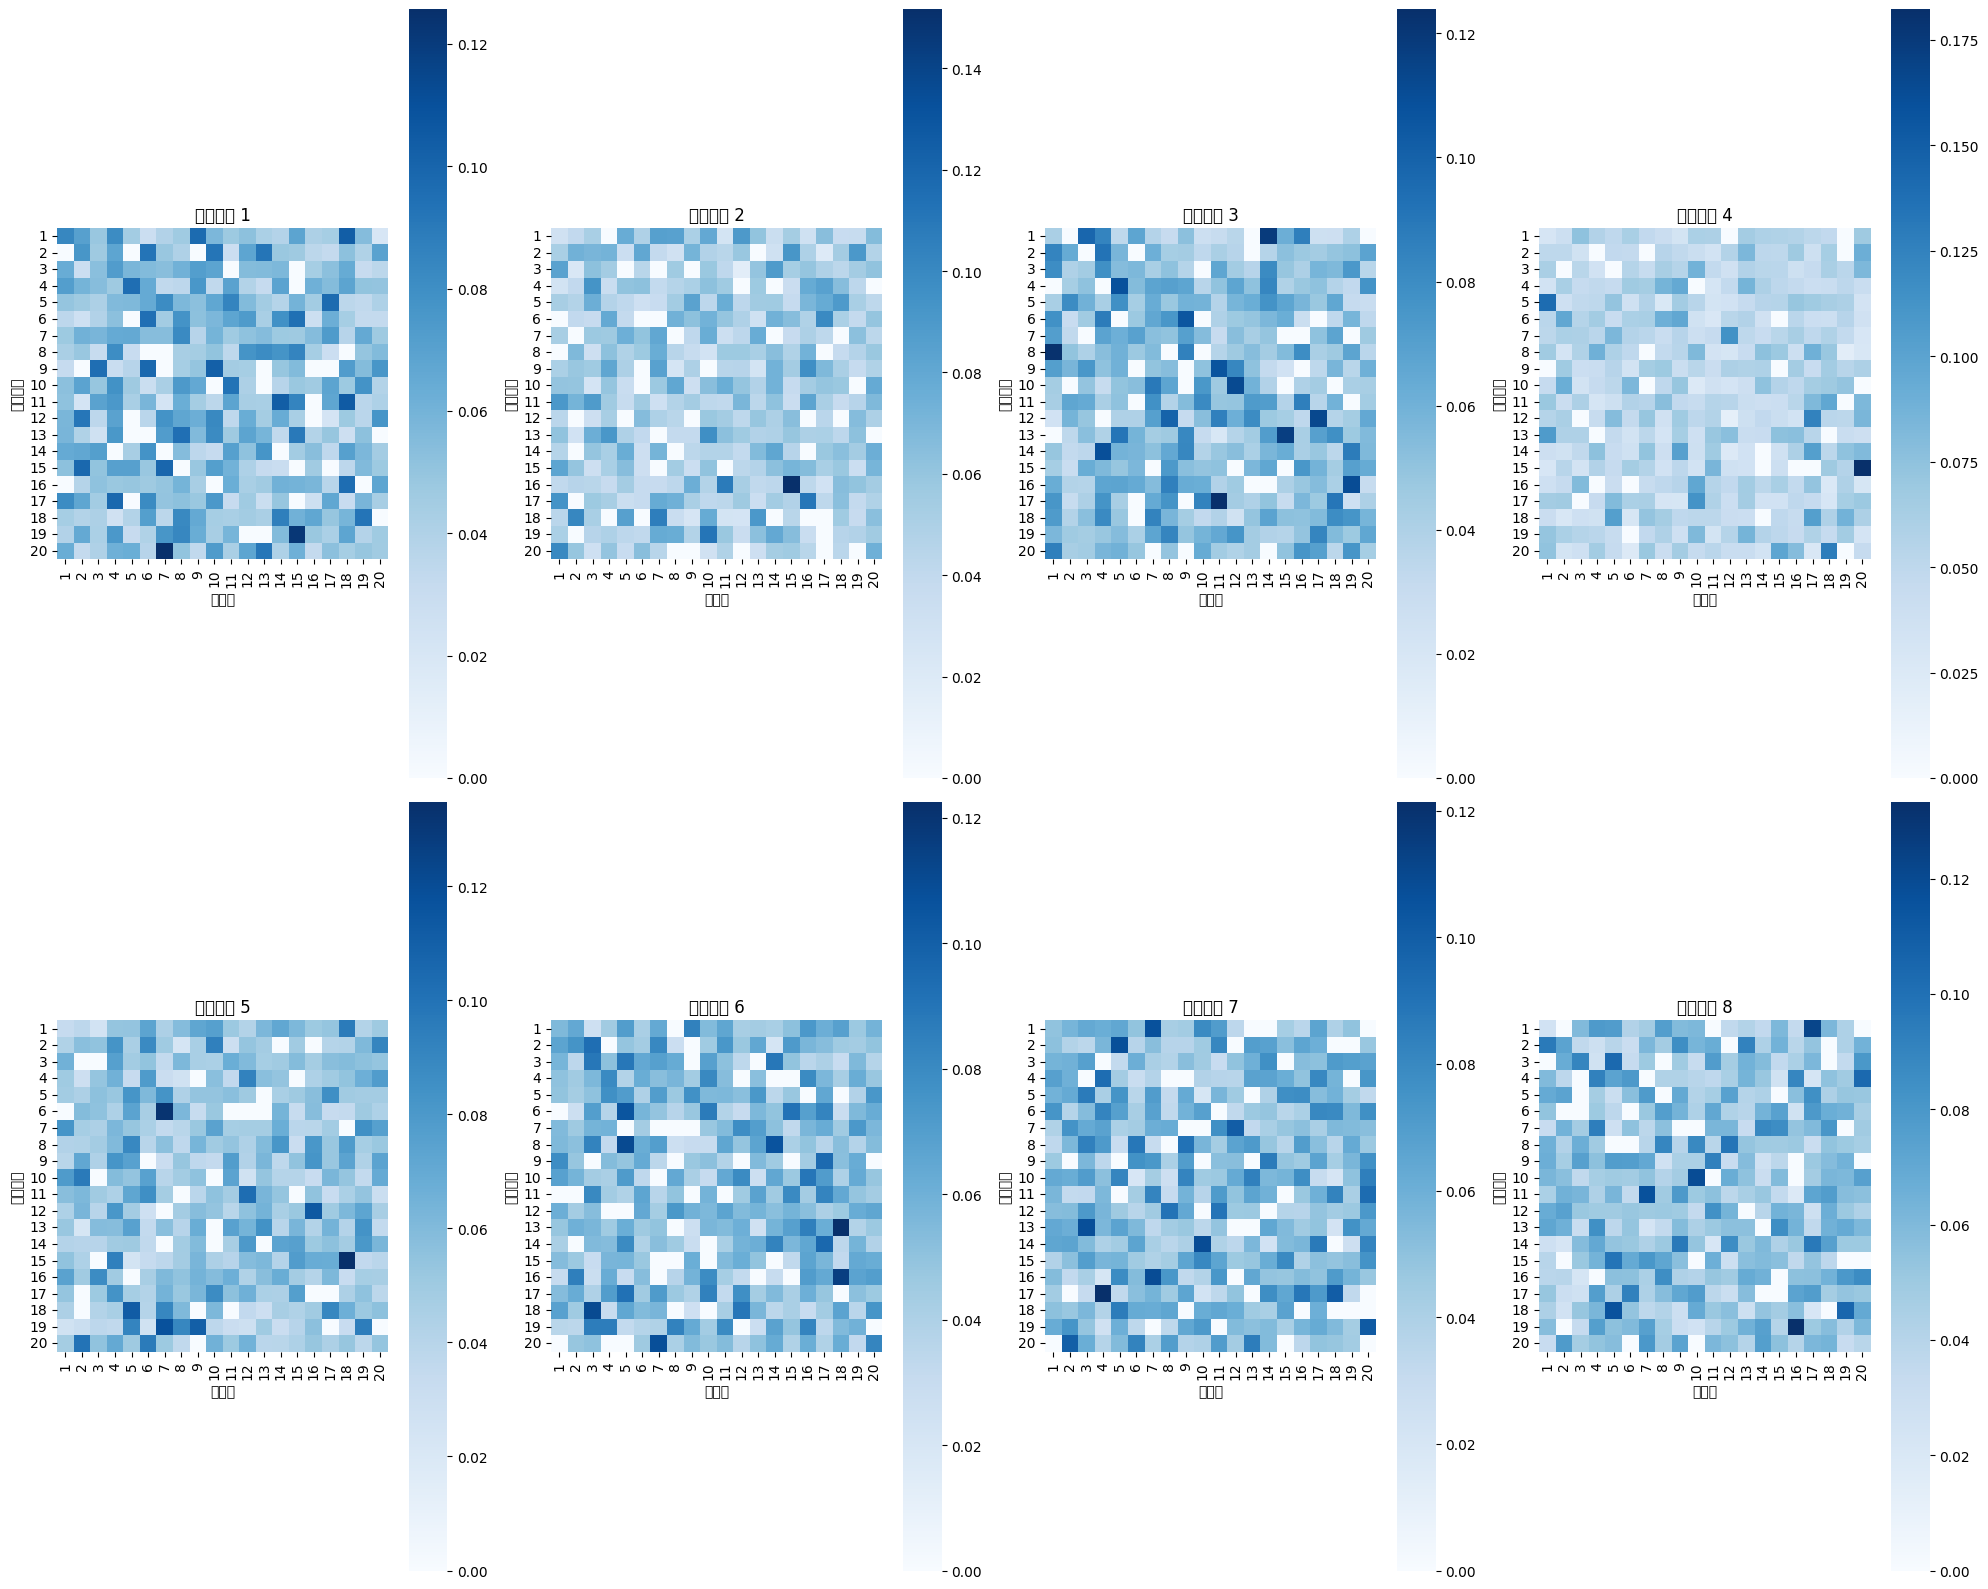

分析注意力模式...
注意力头 1:
  均值: 0.0507
  标准差: 0.0243
  最大值: 0.1257
  最小值: 0.0000
注意力头 2:
  均值: 0.0491
  标准差: 0.0248
  最大值: 0.1517
  最小值: 0.0000
注意力头 3:
  均值: 0.0501
  标准差: 0.0245
  最大值: 0.1239
  最小值: 0.0000
注意力头 4:
  均值: 0.0514
  标准差: 0.0237
  最大值: 0.1823
  最小值: 0.0000
注意力头 5:
  均值: 0.0509
  标准差: 0.0232
  最大值: 0.1349
  最小值: 0.0000
注意力头 6:
  均值: 0.0493
  标准差: 0.0242
  最大值: 0.1226
  最小值: 0.0000
注意力头 7:
  均值: 0.0497
  标准差: 0.0241
  最大值: 0.1214
  最小值: 0.0000
注意力头 8:
  均值: 0.0504
  标准差: 0.0246
  最大值: 0.1334
  最小值: 0.0000

注意力稀疏性分析:
注意力头 1 稀疏性: 9.25%
注意力头 2 稀疏性: 11.50%
注意力头 3 稀疏性: 10.00%
注意力头 4 稀疏性: 7.00%
注意力头 5 稀疏性: 8.25%
注意力头 6 稀疏性: 11.25%
注意力头 7 稀疏性: 10.50%
注意力头 8 稀疏性: 9.75%
✓ 注意力权重可视化完成


In [6]:
def visualize_attention_weights():
    """
    可视化注意力权重
    """
    print("可视化注意力权重...")
    
    # 参数设置
    batch_size = 1
    seq_len = 20
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 1  # 只使用一层便于可视化
    
    # 创建单层编码器
    encoder = Encoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建测试输入
    torch.manual_seed(42)
    x = torch.randn(batch_size, seq_len, d_model)
    
    # 前向传播
    output, attention_weights_list = encoder(x)
    
    # 获取第一层（也是唯一一层）的注意力权重
    attention_weights = attention_weights_list[0]  # [batch_size, n_heads, seq_len, seq_len]
    
    print(f"注意力权重形状: {attention_weights.shape}")
    
    # 绘制注意力权重热力图
    plt.figure(figsize=(20, 16))
    
    # 显示所有注意力头
    for head in range(n_heads):
        plt.subplot(2, 4, head + 1)
        
        # 获取当前头的注意力权重
        head_attention = attention_weights[0, head].detach().numpy()
        
        # 绘制热力图
        sns.heatmap(head_attention, 
                   cmap='Blues', 
                   cbar=True, 
                   square=True,
                   xticklabels=range(1, seq_len + 1),
                   yticklabels=range(1, seq_len + 1))
        
        plt.title(f'注意力头 {head + 1}')
        plt.xlabel('键位置')
        plt.ylabel('查询位置')
    
    plt.tight_layout()
    plt.show()
    
    # 分析注意力模式
    print("分析注意力模式...")
    
    # 计算每个注意力头的统计特性
    for head in range(n_heads):
        head_attention = attention_weights[0, head].detach()
        
        # 计算注意力权重的统计特性
        mean_attention = head_attention.mean().item()
        std_attention = head_attention.std().item()
        max_attention = head_attention.max().item()
        min_attention = head_attention.min().item()
        
        print(f"注意力头 {head + 1}:")
        print(f"  均值: {mean_attention:.4f}")
        print(f"  标准差: {std_attention:.4f}")
        print(f"  最大值: {max_attention:.4f}")
        print(f"  最小值: {min_attention:.4f}")
    
    # 计算注意力权重的稀疏性
    print("\n注意力稀疏性分析:")
    for head in range(n_heads):
        head_attention = attention_weights[0, head].detach()
        
        # 计算注意力权重的稀疏性（接近0的比例）
        sparse_ratio = (head_attention < 0.01).float().mean().item()
        print(f"注意力头 {head + 1} 稀疏性: {sparse_ratio:.2%}")
    
    print("✓ 注意力权重可视化完成")

# 运行可视化
visualize_attention_weights()

## 6. 性能分析

分析编码器性能...
层数 1: 平均时间 0.0109s, 参数量 3,153,408
层数 2: 平均时间 0.0184s, 参数量 6,305,792
层数 4: 平均时间 0.0342s, 参数量 12,610,560
层数 6: 平均时间 0.0516s, 参数量 18,915,328


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1896\1880905136.py:83: UserWarning: Glyph 32534 (\N{CJK UNIFIED IDEOGRAPH-7F16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1896\1880905136.py:83: UserWarning: Glyph 30721 (\N{CJK UNIFIED IDEOGRAPH-7801}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1896\1880905136.py:83: UserWarning: Glyph 22120 (\N{CJK UNIFIED IDEOGRAPH-5668}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1896\1880905136.py:83: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1896\1880905136.py:83: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_1896\188

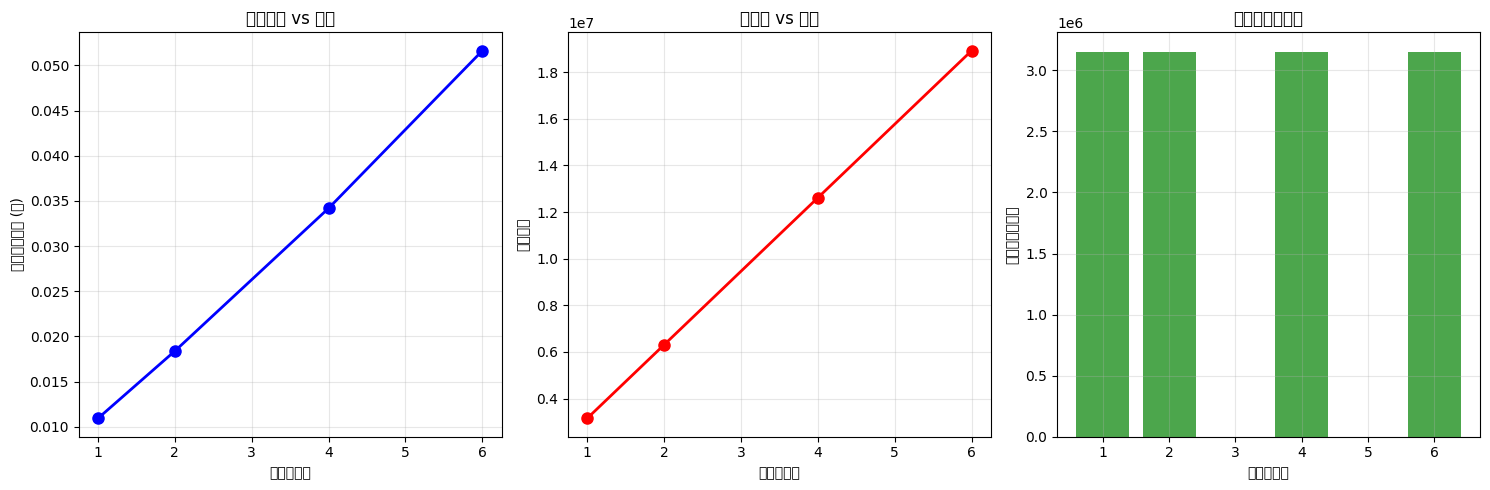


内存使用分析:
1层编码器:
  参数内存: 12.03 MB
  激活内存: 1.39 MB
  总内存: 13.42 MB
6层编码器:
  参数内存: 72.16 MB
  激活内存: 8.35 MB
  总内存: 80.51 MB
✓ 性能分析完成


In [7]:
def analyze_performance():
    """
    分析编码器性能
    """
    print("分析编码器性能...")
    
    import time
    
    # 参数设置
    batch_size = 8
    seq_len = 50
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers_list = [1, 2, 4, 6]
    
    # 创建测试输入
    x = torch.randn(batch_size, seq_len, d_model)
    
    results = []
    
    for n_layers in n_layers_list:
        # 创建编码器
        encoder = Encoder(d_model, n_heads, d_ff, n_layers)
        
        # 预热
        for _ in range(3):
            _ = encoder(x)
        
        # 计时
        start_time = time.time()
        n_iterations = 10
        
        for _ in range(n_iterations):
            output, _ = encoder(x)
        
        end_time = time.time()
        avg_time = (end_time - start_time) / n_iterations
        
        # 计算参数量
        total_params = sum(p.numel() for p in encoder.parameters())
        
        results.append({
            'n_layers': n_layers,
            'avg_time': avg_time,
            'total_params': total_params,
            'params_per_layer': total_params / n_layers
        })
        
        print(f"层数 {n_layers}: 平均时间 {avg_time:.4f}s, 参数量 {total_params:,}")
    
    # 绘制性能分析图
    plt.figure(figsize=(15, 5))
    
    # 子图1: 推理时间 vs 层数
    plt.subplot(1, 3, 1)
    layers = [r['n_layers'] for r in results]
    times = [r['avg_time'] for r in results]
    plt.plot(layers, times, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('编码器层数')
    plt.ylabel('平均推理时间 (秒)')
    plt.title('推理时间 vs 层数')
    plt.grid(True, alpha=0.3)
    
    # 子图2: 参数量 vs 层数
    plt.subplot(1, 3, 2)
    params = [r['total_params'] for r in results]
    plt.plot(layers, params, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('编码器层数')
    plt.ylabel('总参数量')
    plt.title('参数量 vs 层数')
    plt.grid(True, alpha=0.3)
    
    # 子图3: 每层平均参数量
    plt.subplot(1, 3, 3)
    params_per_layer = [r['params_per_layer'] for r in results]
    plt.bar(layers, params_per_layer, alpha=0.7, color='green')
    plt.xlabel('编码器层数')
    plt.ylabel('每层平均参数量')
    plt.title('每层平均参数量')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 分析内存使用
    print("\n内存使用分析:")
    
    # 计算不同配置的理论内存使用
    for n_layers in [1, 6]:
        # 参数量（以MB为单位，假设float32）
        params_mb = sum(p.numel() for p in Encoder(d_model, n_heads, d_ff, n_layers).parameters()) * 4 / (1024**2)
        
        # 激活值内存（粗略估计）
        # 每层输出: batch_size * seq_len * d_model
        # 注意力权重: batch_size * n_heads * seq_len * seq_len
        activation_memory = (batch_size * seq_len * d_model * n_layers + 
                           batch_size * n_heads * seq_len * seq_len * n_layers) * 4 / (1024**2)
        
        total_memory = params_mb + activation_memory
        
        print(f"{n_layers}层编码器:")
        print(f"  参数内存: {params_mb:.2f} MB")
        print(f"  激活内存: {activation_memory:.2f} MB")
        print(f"  总内存: {total_memory:.2f} MB")
    
    print("✓ 性能分析完成")

# 运行性能分析
analyze_performance()

## 7. 与PyTorch官方实现对比

In [8]:
def compare_with_pytorch_transformer():
    """
    与PyTorch官方Transformer编码器对比
    """
    print("与PyTorch官方Transformer编码器对比...")
    
    # 参数设置
    batch_size = 2
    seq_len = 10
    d_model = 512
    n_heads = 8
    d_ff = 2048
    n_layers = 6
    
    # 创建我们的编码器
    our_encoder = Encoder(d_model, n_heads, d_ff, n_layers)
    
    # 创建PyTorch官方Transformer编码器
    pytorch_encoder_layer = nn.TransformerEncoderLayer(
        d_model=d_model,
        nhead=n_heads,
        dim_feedforward=d_ff,
        dropout=0.1,
        activation='relu'
    )
    pytorch_encoder = nn.TransformerEncoder(pytorch_encoder_layer, num_layers=n_layers)
    
    # 创建相同的输入
    torch.manual_seed(42)
    x = torch.randn(batch_size, seq_len, d_model)
    
    print(f"输入形状: {x.shape}")
    
    # 我们的编码器前向传播
    our_output, our_attention_weights = our_encoder(x)
    
    # PyTorch编码器前向传播
    # 注意：PyTorch的Transformer期望输入形状为 (seq_len, batch_size, d_model)
    pytorch_input = x.transpose(0, 1)  # 调整维度
    pytorch_output = pytorch_encoder(pytorch_input)
    pytorch_output = pytorch_output.transpose(0, 1)  # 调整回 (batch_size, seq_len, d_model)
    
    print(f"我们的输出形状: {our_output.shape}")
    print(f"PyTorch输出形状: {pytorch_output.shape}")
    
    # 比较参数量
    our_params = sum(p.numel() for p in our_encoder.parameters())
    pytorch_params = sum(p.numel() for p in pytorch_encoder.parameters())
    
    print(f"我们的参数量: {our_params:,}")
    print(f"PyTorch参数量: {pytorch_params:,}")
    print(f"参数差异: {abs(our_params - pytorch_params):,}")
    
    # 比较输出范围
    print(f"我们的输出范围: [{our_output.min().item():.3f}, {our_output.max().item():.3f}]")
    print(f"PyTorch输出范围: [{pytorch_output.min().item():.3f}, {pytorch_output.max().item():.3f}]")
    
    # 由于初始化不同，输出会有差异，但应该在一个合理的范围内
    # 这里我们主要比较架构和参数量的相似性
    
    print("✓ 与PyTorch官方实现对比完成")
    
    return our_output, pytorch_output

# 运行对比
our_output, pytorch_output = compare_with_pytorch_transformer()

与PyTorch官方Transformer编码器对比...
输入形状: torch.Size([2, 10, 512])
我们的输出形状: torch.Size([2, 10, 512])
PyTorch输出形状: torch.Size([2, 10, 512])
我们的参数量: 18,915,328
PyTorch参数量: 18,914,304
参数差异: 1,024
我们的输出范围: [-3.692, 4.091]
PyTorch输出范围: [-5.282, 3.774]
✓ 与PyTorch官方实现对比完成


e:\Application\Anaconda\envs\llm\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## 8. 总结

在这个notebook中，我们完整实现了Transformer的编码器结构：

### 1. 位置前馈网络（Positionwise Feed-Forward）
- **架构**: 两个线性层 + ReLU激活
- **维度**: 512 → 2048 → 512
- **特点**: 应用于每个位置，参数共享

### 2. 编码器层（Encoder Layer）
- **子层1**: 多头自注意力 + 残差连接 + 层归一化
- **子层2**: 位置前馈网络 + 残差连接 + 层归一化
- **正则化**: Dropout

### 3. 完整编码器（Encoder）
- **层数**: 6个相同的编码器层
- **输入**: 嵌入 + 位置编码
- **输出**: 上下文表示

### 4. 关键特性
1. **残差连接**: 解决梯度消失问题
2. **层归一化**: 稳定训练过程
3. **多头注意力**: 捕获不同表示子空间的信息
4. **位置前馈**: 提供非线性变换能力

### 5. 性能特点
- **时间复杂度**: O(n²d)（主要来自注意力机制）
- **空间复杂度**: O(n²)（注意力权重矩阵）
- **并行性**: 高（相比RNN）

### 下一步：

接下来我们将实现Transformer的解码器，它将在编码器的基础上添加编码器-解码器注意力机制。